# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatened_layers = layers.concatenate([upsampled_layer, large_ip_layer])    
    # TODO Add some number of separable convolution layers
    separable_layer = separable_conv2d_batchnorm(concatened_layers, filters, 1)
    output_layer = separable_conv2d_batchnorm(separable_layer, filters, 1)    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    print("Input shape", inputs.shape)    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1_layer = encoder_block(inputs, 32, 2)
    encoder_2_layer = encoder_block(encoder_1_layer, 64, 2)
    encoder_3_layer = encoder_block(encoder_2_layer, 128, 2)
    print("encoder_1_layer", encoder_1_layer.shape)
    print("encoder_2_layer", encoder_2_layer.shape)
    print("encoder_3_layer", encoder_3_layer.shape)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1_1_layer = conv2d_batchnorm(encoder_3_layer, 128, 1, 1)
    print("conv_1_1_layer", conv_1_1_layer.shape)    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1_layer = decoder_block(conv_1_1_layer, encoder_2_layer, 128)
    print("decoder_1_layer", decoder_1_layer.shape)
    decoder_2_layer = decoder_block(decoder_1_layer, encoder_1_layer, 64)
    print("decoder_2_layer", decoder_2_layer.shape)
    decoder_3_layer = decoder_block(decoder_2_layer, inputs, 32)
    print("decoder_3_layer", decoder_2_layer.shape)       
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    output_layer = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_3_layer)
    print("Output Layer", output_layer.shape)
    return output_layer

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Input shape (?, 160, 160, 3)
encoder_1_layer (?, 80, 80, 32)
encoder_2_layer (?, 40, 40, 64)
encoder_3_layer (?, 20, 20, 128)
conv_1_1_layer (?, 20, 20, 128)
decoder_1_layer (?, 40, 40, 128)
decoder_2_layer (?, 80, 80, 64)
decoder_3_layer (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.01 # 0.0001 last value
batch_size = 32
num_epochs = 115
steps_per_epoch = 200
validation_steps = 50
workers = 2

In [11]:
pwd

'/home/workspace/RoboND-DeepLearning-Project/code'

Epoch 1/115
199/200 [============================>.] - ETA: 0s - loss: 0.1194

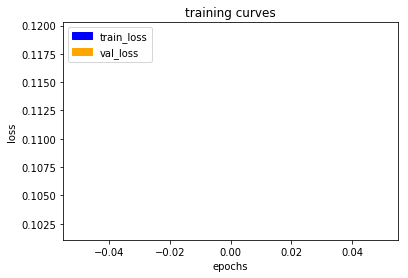

200/200 [==============================] - 116s - loss: 0.1190 - val_loss: 0.1020
Epoch 2/115
199/200 [============================>.] - ETA: 0s - loss: 0.0392

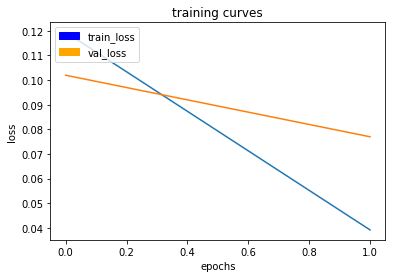

200/200 [==============================] - 113s - loss: 0.0392 - val_loss: 0.0770
Epoch 3/115
199/200 [============================>.] - ETA: 0s - loss: 0.0339

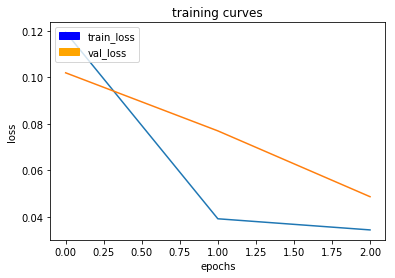

200/200 [==============================] - 113s - loss: 0.0343 - val_loss: 0.0487
Epoch 4/115
199/200 [============================>.] - ETA: 0s - loss: 0.0299

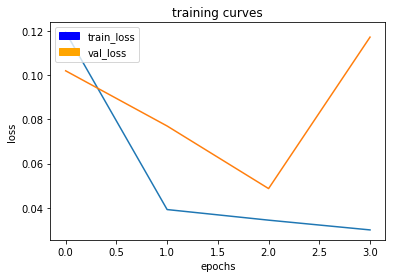

200/200 [==============================] - 113s - loss: 0.0298 - val_loss: 0.1172
Epoch 5/115
199/200 [============================>.] - ETA: 0s - loss: 0.0287

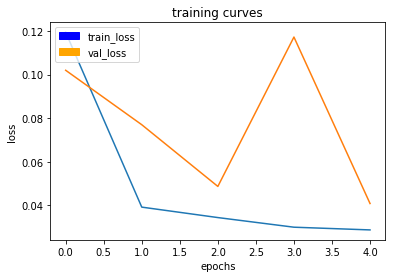

200/200 [==============================] - 114s - loss: 0.0287 - val_loss: 0.0408
Epoch 6/115
199/200 [============================>.] - ETA: 0s - loss: 0.0260

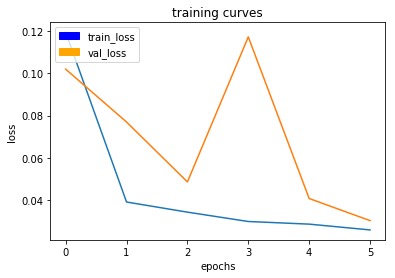

200/200 [==============================] - 113s - loss: 0.0260 - val_loss: 0.0304
Epoch 7/115
199/200 [============================>.] - ETA: 0s - loss: 0.0246

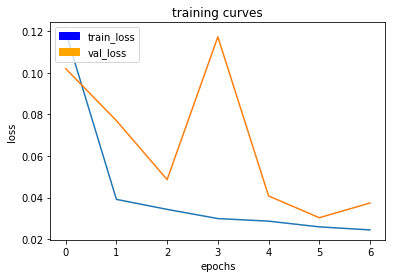

200/200 [==============================] - 114s - loss: 0.0245 - val_loss: 0.0374
Epoch 8/115
199/200 [============================>.] - ETA: 0s - loss: 0.0242

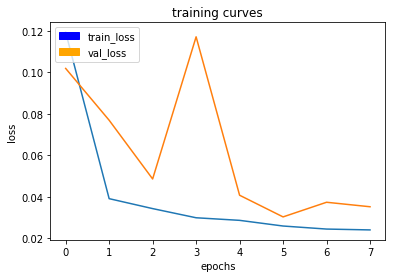

200/200 [==============================] - 112s - loss: 0.0242 - val_loss: 0.0353
Epoch 9/115
199/200 [============================>.] - ETA: 0s - loss: 0.0222

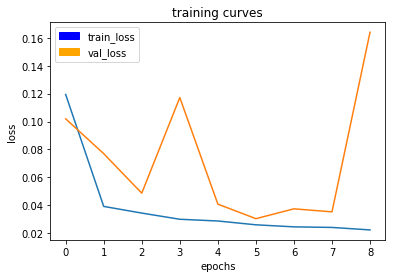

200/200 [==============================] - 114s - loss: 0.0223 - val_loss: 0.1640
Epoch 10/115
199/200 [============================>.] - ETA: 0s - loss: 0.0229

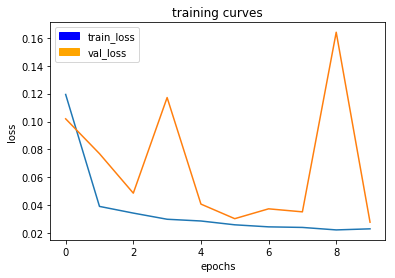

200/200 [==============================] - 113s - loss: 0.0230 - val_loss: 0.0278
Epoch 11/115
199/200 [============================>.] - ETA: 0s - loss: 0.0209

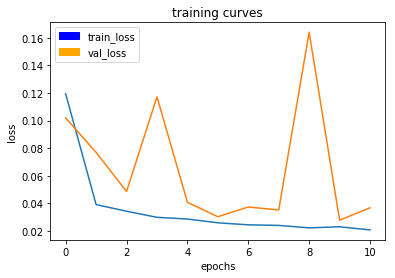

200/200 [==============================] - 113s - loss: 0.0209 - val_loss: 0.0369
Epoch 12/115
199/200 [============================>.] - ETA: 0s - loss: 0.0211

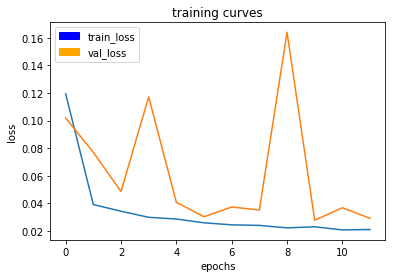

200/200 [==============================] - 113s - loss: 0.0211 - val_loss: 0.0292
Epoch 13/115
199/200 [============================>.] - ETA: 0s - loss: 0.0187

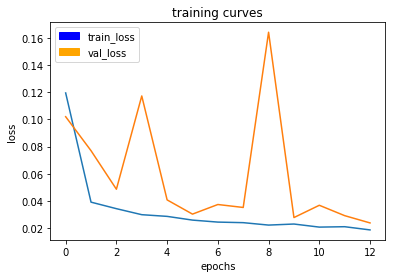

200/200 [==============================] - 114s - loss: 0.0187 - val_loss: 0.0239
Epoch 14/115
199/200 [============================>.] - ETA: 0s - loss: 0.0196

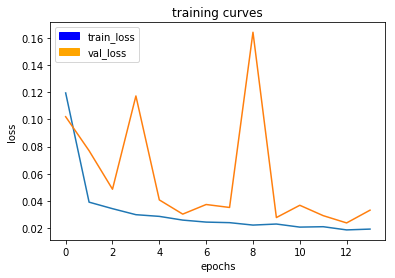

200/200 [==============================] - 115s - loss: 0.0195 - val_loss: 0.0333
Epoch 15/115
199/200 [============================>.] - ETA: 0s - loss: 0.0196

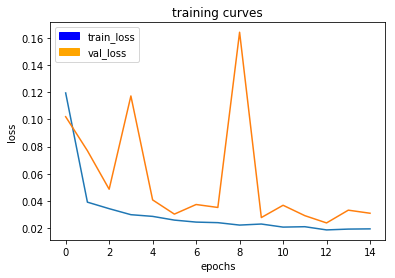

200/200 [==============================] - 113s - loss: 0.0196 - val_loss: 0.0310
Epoch 16/115
199/200 [============================>.] - ETA: 0s - loss: 0.0177

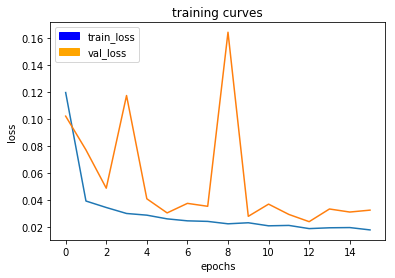

200/200 [==============================] - 114s - loss: 0.0178 - val_loss: 0.0324
Epoch 17/115
199/200 [============================>.] - ETA: 0s - loss: 0.0173

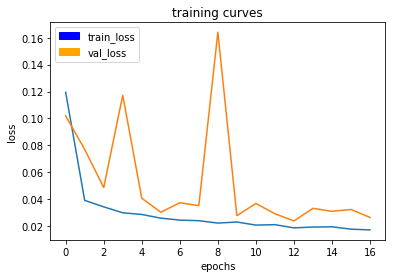

200/200 [==============================] - 114s - loss: 0.0173 - val_loss: 0.0265
Epoch 18/115
199/200 [============================>.] - ETA: 0s - loss: 0.0193

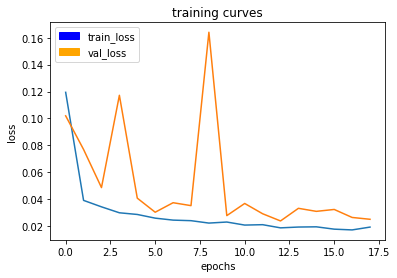

200/200 [==============================] - 113s - loss: 0.0193 - val_loss: 0.0251
Epoch 19/115
199/200 [============================>.] - ETA: 0s - loss: 0.0157

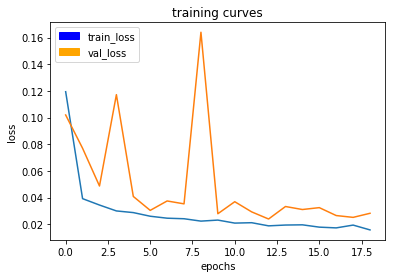

200/200 [==============================] - 113s - loss: 0.0157 - val_loss: 0.0282
Epoch 20/115
199/200 [============================>.] - ETA: 0s - loss: 0.0176

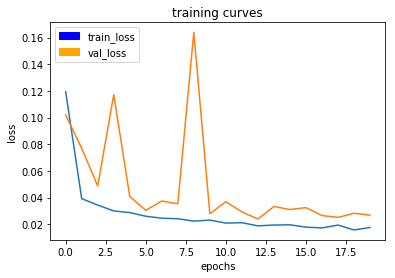

200/200 [==============================] - 113s - loss: 0.0176 - val_loss: 0.0268
Epoch 21/115
199/200 [============================>.] - ETA: 0s - loss: 0.0160

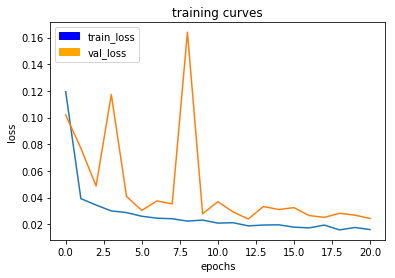

200/200 [==============================] - 114s - loss: 0.0160 - val_loss: 0.0243
Epoch 22/115
199/200 [============================>.] - ETA: 0s - loss: 0.0162

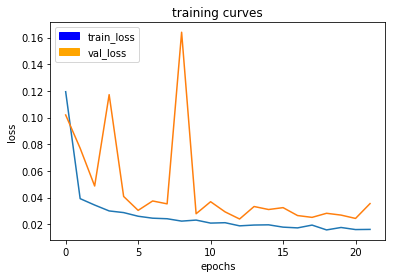

200/200 [==============================] - 113s - loss: 0.0162 - val_loss: 0.0354
Epoch 23/115
199/200 [============================>.] - ETA: 0s - loss: 0.0164

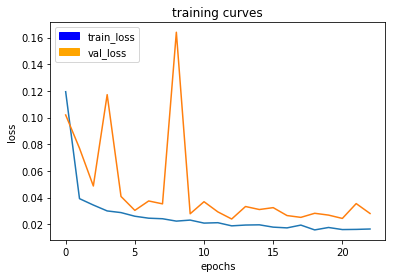

200/200 [==============================] - 113s - loss: 0.0164 - val_loss: 0.0280
Epoch 24/115
199/200 [============================>.] - ETA: 0s - loss: 0.0152

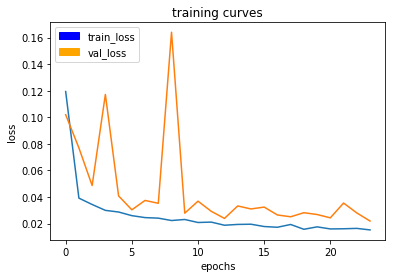

200/200 [==============================] - 114s - loss: 0.0152 - val_loss: 0.0219
Epoch 25/115
199/200 [============================>.] - ETA: 0s - loss: 0.0149

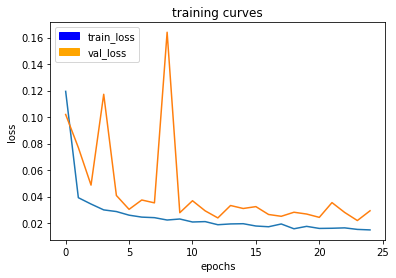

200/200 [==============================] - 113s - loss: 0.0149 - val_loss: 0.0293
Epoch 26/115
199/200 [============================>.] - ETA: 0s - loss: 0.0138

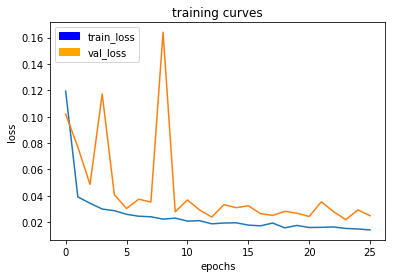

200/200 [==============================] - 113s - loss: 0.0141 - val_loss: 0.0249
Epoch 27/115
199/200 [============================>.] - ETA: 0s - loss: 0.0138

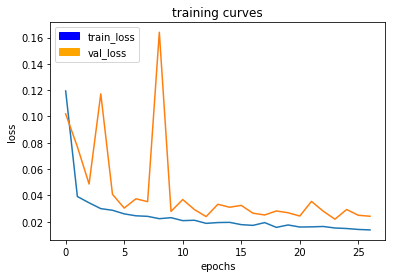

200/200 [==============================] - 113s - loss: 0.0138 - val_loss: 0.0242
Epoch 28/115
199/200 [============================>.] - ETA: 0s - loss: 0.0154

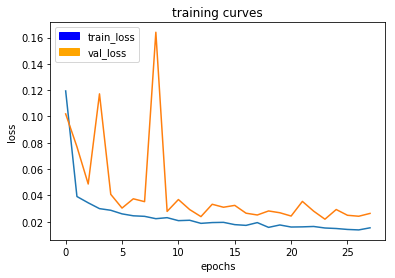

200/200 [==============================] - 113s - loss: 0.0154 - val_loss: 0.0263
Epoch 29/115
199/200 [============================>.] - ETA: 0s - loss: 0.0174

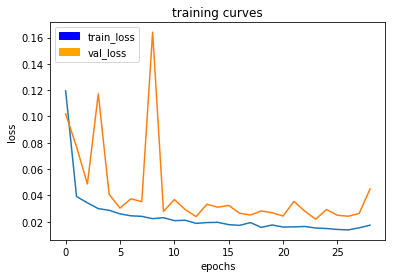

200/200 [==============================] - 114s - loss: 0.0174 - val_loss: 0.0449
Epoch 30/115
199/200 [============================>.] - ETA: 0s - loss: 0.0161

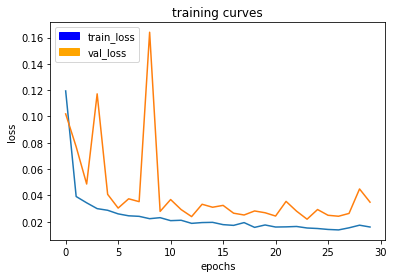

200/200 [==============================] - 113s - loss: 0.0160 - val_loss: 0.0349
Epoch 31/115
199/200 [============================>.] - ETA: 0s - loss: 0.0145

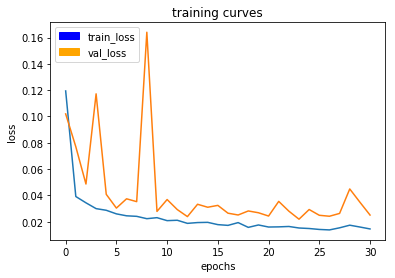

200/200 [==============================] - 114s - loss: 0.0145 - val_loss: 0.0251
Epoch 32/115
199/200 [============================>.] - ETA: 0s - loss: 0.0131

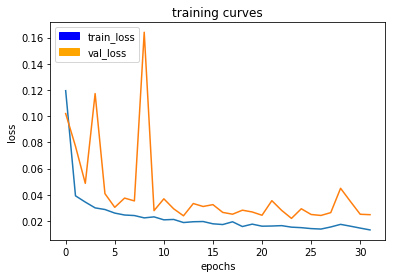

200/200 [==============================] - 113s - loss: 0.0131 - val_loss: 0.0247
Epoch 33/115
199/200 [============================>.] - ETA: 0s - loss: 0.0196

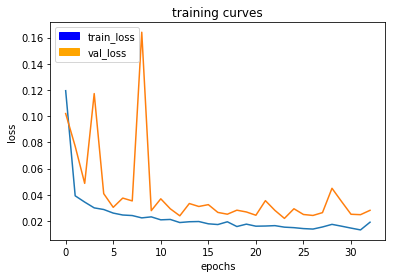

200/200 [==============================] - 113s - loss: 0.0196 - val_loss: 0.0281
Epoch 34/115
199/200 [============================>.] - ETA: 0s - loss: 0.0151

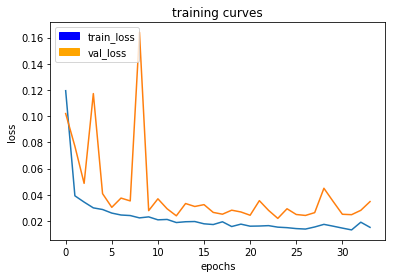

200/200 [==============================] - 114s - loss: 0.0151 - val_loss: 0.0347
Epoch 35/115
199/200 [============================>.] - ETA: 0s - loss: 0.0142

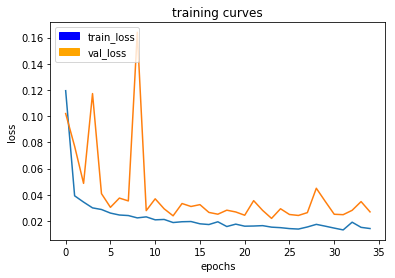

200/200 [==============================] - 114s - loss: 0.0142 - val_loss: 0.0269
Epoch 36/115
199/200 [============================>.] - ETA: 0s - loss: 0.0124

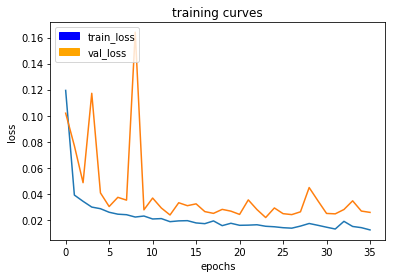

200/200 [==============================] - 113s - loss: 0.0124 - val_loss: 0.0259
Epoch 37/115
199/200 [============================>.] - ETA: 0s - loss: 0.0128

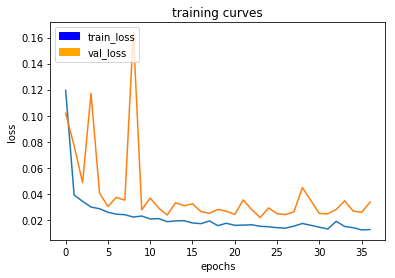

200/200 [==============================] - 114s - loss: 0.0128 - val_loss: 0.0338
Epoch 38/115
199/200 [============================>.] - ETA: 0s - loss: 0.0144

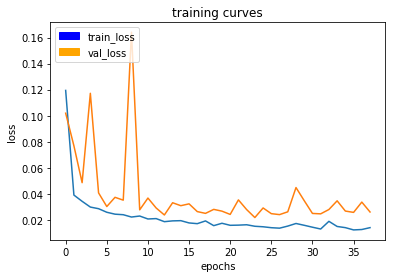

200/200 [==============================] - 113s - loss: 0.0144 - val_loss: 0.0262
Epoch 39/115
199/200 [============================>.] - ETA: 0s - loss: 0.0121

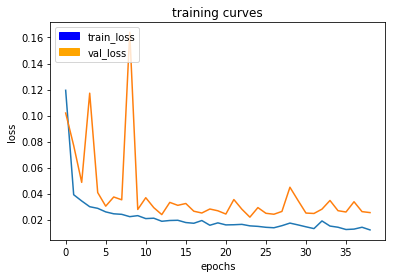

200/200 [==============================] - 114s - loss: 0.0121 - val_loss: 0.0254
Epoch 40/115
199/200 [============================>.] - ETA: 0s - loss: 0.0133

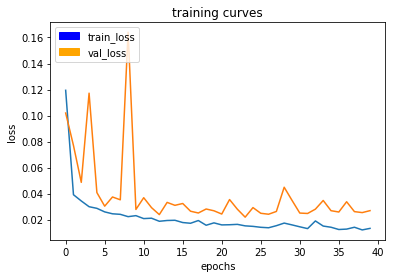

200/200 [==============================] - 114s - loss: 0.0133 - val_loss: 0.0269
Epoch 41/115
199/200 [============================>.] - ETA: 0s - loss: 0.0127

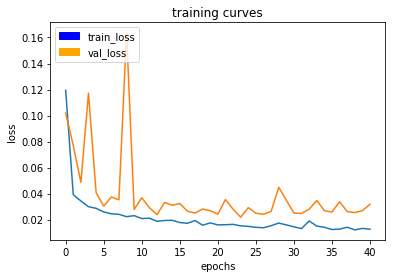

200/200 [==============================] - 113s - loss: 0.0127 - val_loss: 0.0318
Epoch 42/115
199/200 [============================>.] - ETA: 0s - loss: 0.0133

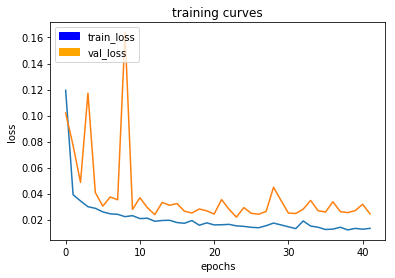

200/200 [==============================] - 113s - loss: 0.0133 - val_loss: 0.0244
Epoch 43/115
199/200 [============================>.] - ETA: 0s - loss: 0.0131

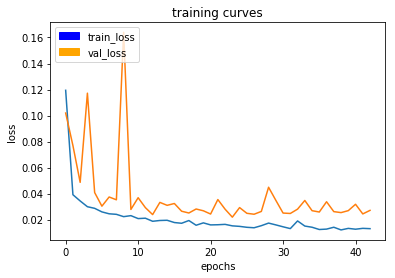

200/200 [==============================] - 113s - loss: 0.0131 - val_loss: 0.0271
Epoch 44/115
199/200 [============================>.] - ETA: 0s - loss: 0.0116

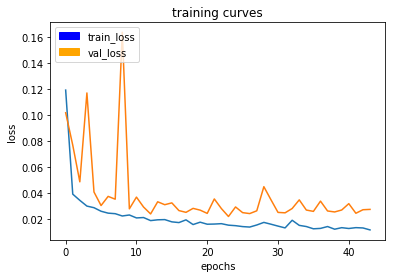

200/200 [==============================] - 114s - loss: 0.0116 - val_loss: 0.0274
Epoch 45/115
199/200 [============================>.] - ETA: 0s - loss: 0.0120

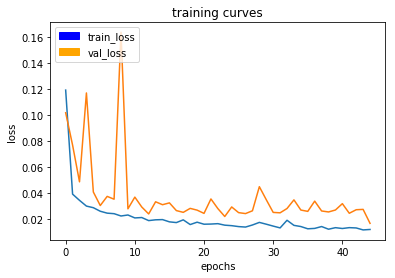

200/200 [==============================] - 113s - loss: 0.0119 - val_loss: 0.0166
Epoch 46/115
199/200 [============================>.] - ETA: 0s - loss: 0.0118

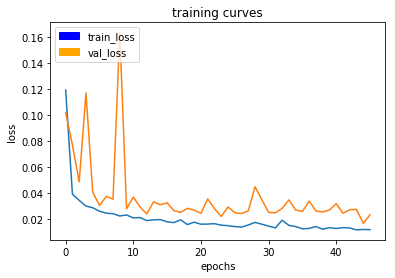

200/200 [==============================] - 115s - loss: 0.0118 - val_loss: 0.0233
Epoch 47/115
199/200 [============================>.] - ETA: 0s - loss: 0.0136

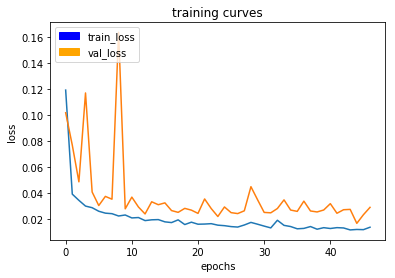

200/200 [==============================] - 113s - loss: 0.0136 - val_loss: 0.0290
Epoch 48/115
199/200 [============================>.] - ETA: 0s - loss: 0.0119

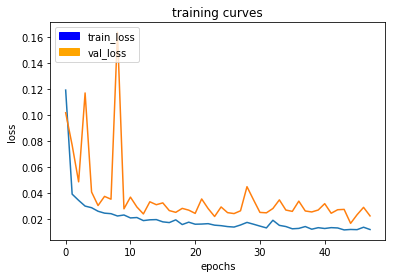

200/200 [==============================] - 114s - loss: 0.0119 - val_loss: 0.0224
Epoch 49/115
199/200 [============================>.] - ETA: 0s - loss: 0.0121

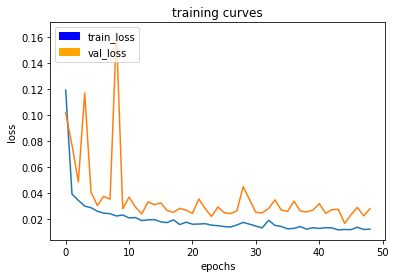

200/200 [==============================] - 113s - loss: 0.0121 - val_loss: 0.0279
Epoch 50/115
199/200 [============================>.] - ETA: 0s - loss: 0.0112

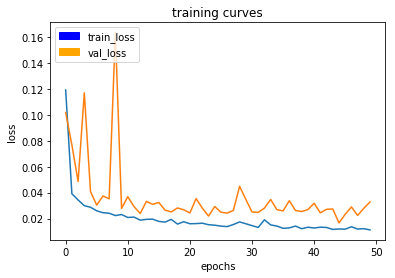

200/200 [==============================] - 113s - loss: 0.0112 - val_loss: 0.0328
Epoch 51/115
199/200 [============================>.] - ETA: 0s - loss: 0.0118

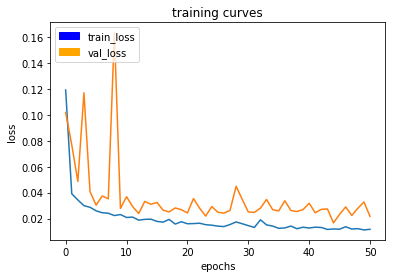

200/200 [==============================] - 113s - loss: 0.0118 - val_loss: 0.0217
Epoch 52/115
199/200 [============================>.] - ETA: 0s - loss: 0.0107

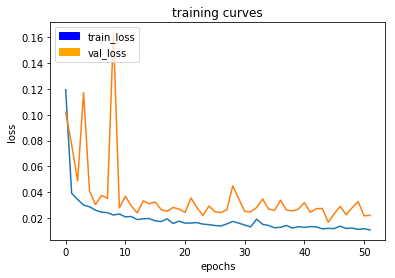

200/200 [==============================] - 113s - loss: 0.0107 - val_loss: 0.0220
Epoch 53/115
199/200 [============================>.] - ETA: 0s - loss: 0.0100

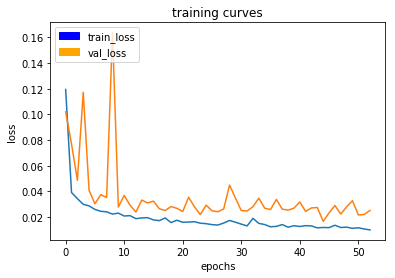

200/200 [==============================] - 114s - loss: 0.0100 - val_loss: 0.0251
Epoch 54/115
199/200 [============================>.] - ETA: 0s - loss: 0.0109

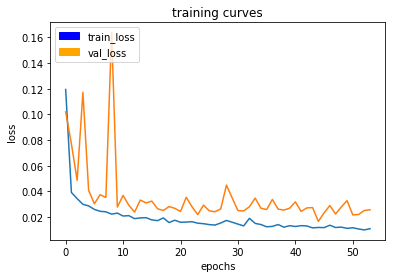

200/200 [==============================] - 114s - loss: 0.0109 - val_loss: 0.0257
Epoch 55/115
199/200 [============================>.] - ETA: 0s - loss: 0.0109

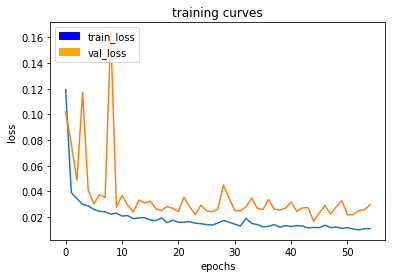

200/200 [==============================] - 115s - loss: 0.0109 - val_loss: 0.0297
Epoch 56/115
199/200 [============================>.] - ETA: 0s - loss: 0.0132

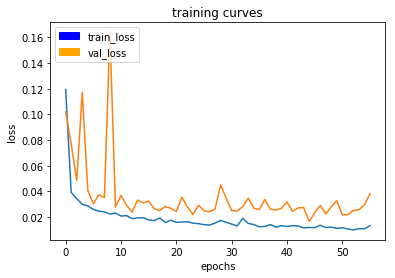

200/200 [==============================] - 113s - loss: 0.0132 - val_loss: 0.0382
Epoch 57/115
199/200 [============================>.] - ETA: 0s - loss: 0.0122

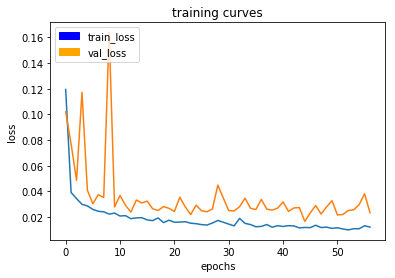

200/200 [==============================] - 114s - loss: 0.0122 - val_loss: 0.0233
Epoch 58/115
199/200 [============================>.] - ETA: 0s - loss: 0.0123

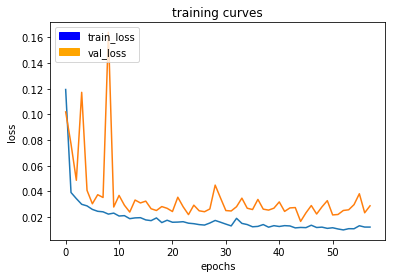

200/200 [==============================] - 113s - loss: 0.0123 - val_loss: 0.0288
Epoch 59/115
199/200 [============================>.] - ETA: 0s - loss: 0.0116

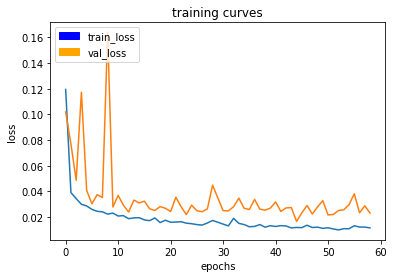

200/200 [==============================] - 114s - loss: 0.0115 - val_loss: 0.0231
Epoch 60/115
199/200 [============================>.] - ETA: 0s - loss: 0.0117

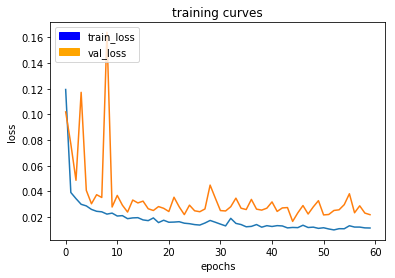

200/200 [==============================] - 113s - loss: 0.0116 - val_loss: 0.0218
Epoch 61/115
199/200 [============================>.] - ETA: 0s - loss: 0.0109

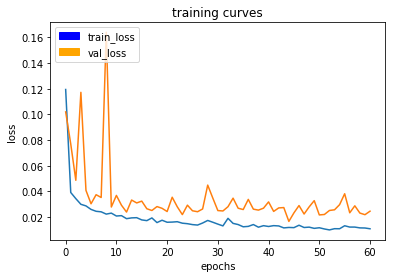

200/200 [==============================] - 114s - loss: 0.0109 - val_loss: 0.0246
Epoch 62/115
199/200 [============================>.] - ETA: 0s - loss: 0.0102

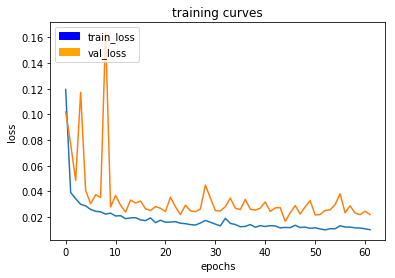

200/200 [==============================] - 114s - loss: 0.0102 - val_loss: 0.0219
Epoch 63/115
199/200 [============================>.] - ETA: 0s - loss: 0.0106

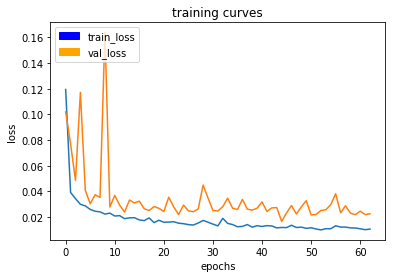

200/200 [==============================] - 114s - loss: 0.0106 - val_loss: 0.0226
Epoch 64/115
199/200 [============================>.] - ETA: 0s - loss: 0.0117

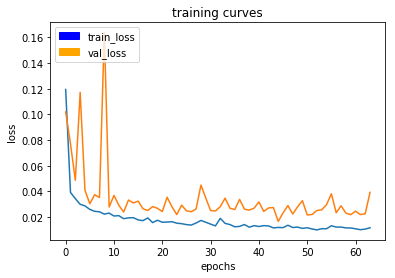

200/200 [==============================] - 114s - loss: 0.0117 - val_loss: 0.0393
Epoch 65/115
199/200 [============================>.] - ETA: 0s - loss: 0.0115

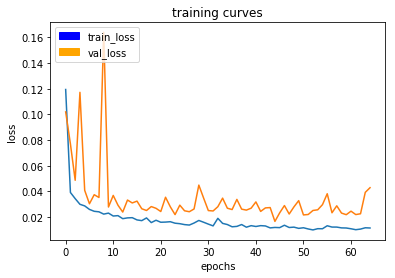

200/200 [==============================] - 113s - loss: 0.0115 - val_loss: 0.0429
Epoch 66/115
199/200 [============================>.] - ETA: 0s - loss: 0.0121

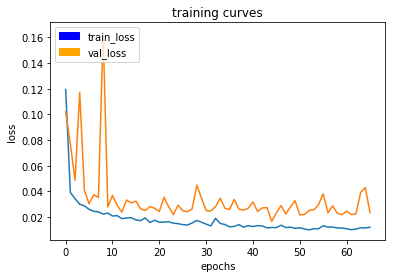

200/200 [==============================] - 114s - loss: 0.0121 - val_loss: 0.0234
Epoch 67/115
199/200 [============================>.] - ETA: 0s - loss: 0.0103

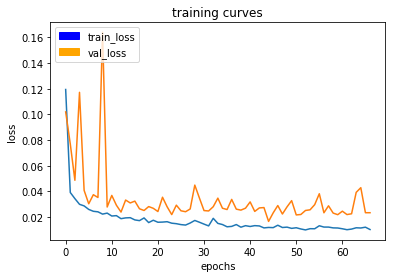

200/200 [==============================] - 114s - loss: 0.0103 - val_loss: 0.0234
Epoch 68/115
199/200 [============================>.] - ETA: 0s - loss: 0.0095

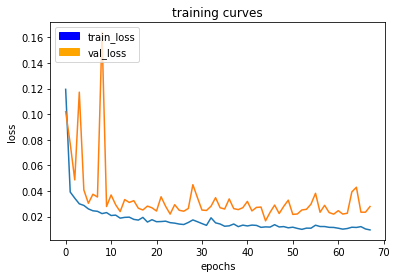

200/200 [==============================] - 114s - loss: 0.0095 - val_loss: 0.0278
Epoch 69/115
199/200 [============================>.] - ETA: 0s - loss: 0.0097

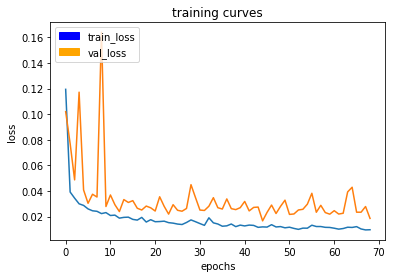

200/200 [==============================] - 113s - loss: 0.0097 - val_loss: 0.0185
Epoch 70/115
199/200 [============================>.] - ETA: 0s - loss: 0.0115

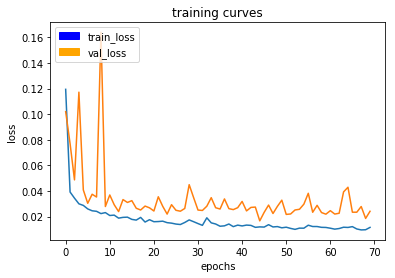

200/200 [==============================] - 114s - loss: 0.0115 - val_loss: 0.0241
Epoch 71/115
199/200 [============================>.] - ETA: 0s - loss: 0.0110

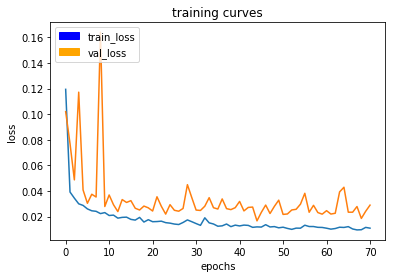

200/200 [==============================] - 113s - loss: 0.0110 - val_loss: 0.0289
Epoch 72/115
199/200 [============================>.] - ETA: 0s - loss: 0.0100

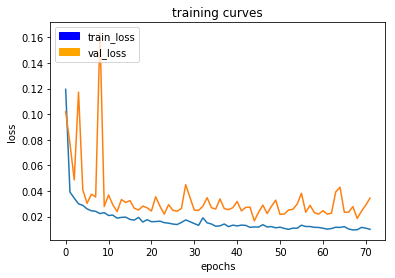

200/200 [==============================] - 114s - loss: 0.0100 - val_loss: 0.0344
Epoch 73/115
199/200 [============================>.] - ETA: 0s - loss: 0.0113

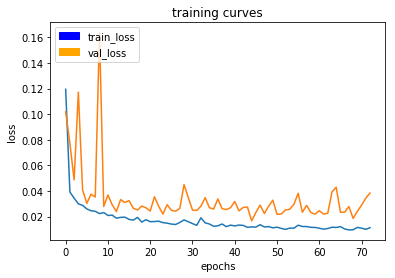

200/200 [==============================] - 113s - loss: 0.0113 - val_loss: 0.0383
Epoch 74/115
199/200 [============================>.] - ETA: 0s - loss: 0.0221

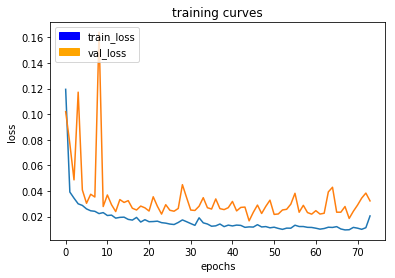

200/200 [==============================] - 114s - loss: 0.0221 - val_loss: 0.0322
Epoch 75/115
199/200 [============================>.] - ETA: 0s - loss: 0.0155

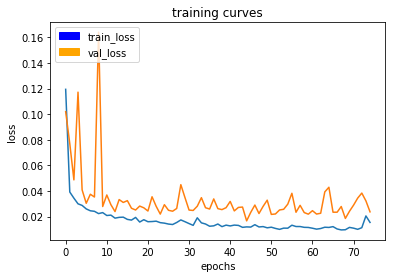

200/200 [==============================] - 113s - loss: 0.0155 - val_loss: 0.0237
Epoch 76/115
199/200 [============================>.] - ETA: 0s - loss: 0.0125

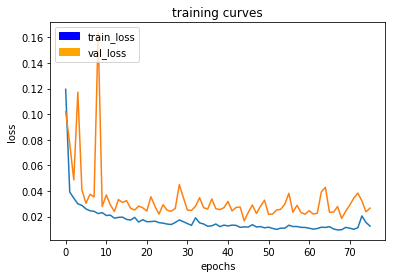

200/200 [==============================] - 113s - loss: 0.0125 - val_loss: 0.0266
Epoch 77/115
199/200 [============================>.] - ETA: 0s - loss: 0.0112

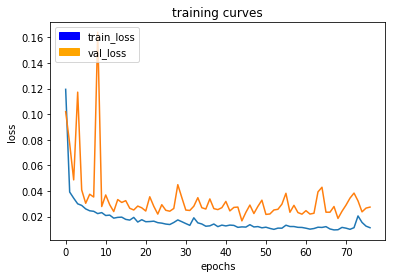

200/200 [==============================] - 114s - loss: 0.0112 - val_loss: 0.0274
Epoch 78/115
199/200 [============================>.] - ETA: 0s - loss: 0.0106

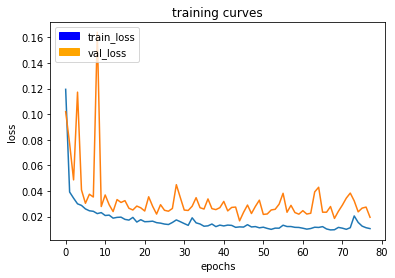

200/200 [==============================] - 113s - loss: 0.0106 - val_loss: 0.0194
Epoch 79/115
199/200 [============================>.] - ETA: 0s - loss: 0.0104

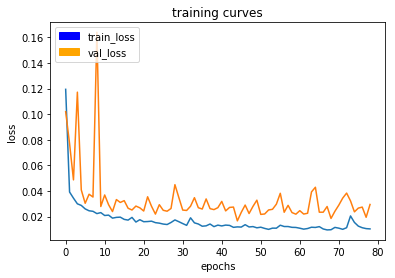

200/200 [==============================] - 114s - loss: 0.0103 - val_loss: 0.0294
Epoch 80/115
199/200 [============================>.] - ETA: 0s - loss: 0.0097

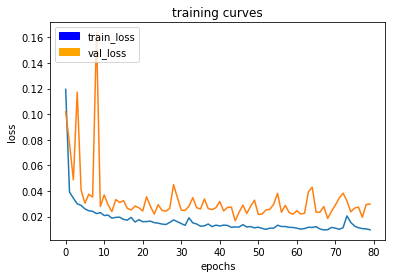

200/200 [==============================] - 114s - loss: 0.0097 - val_loss: 0.0298
Epoch 81/115
199/200 [============================>.] - ETA: 0s - loss: 0.0095

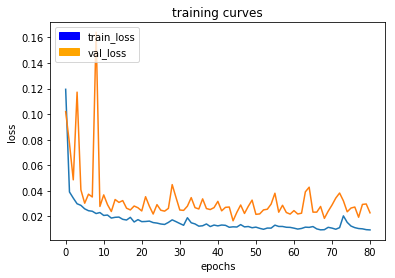

200/200 [==============================] - 113s - loss: 0.0095 - val_loss: 0.0229
Epoch 82/115
199/200 [============================>.] - ETA: 0s - loss: 0.0102

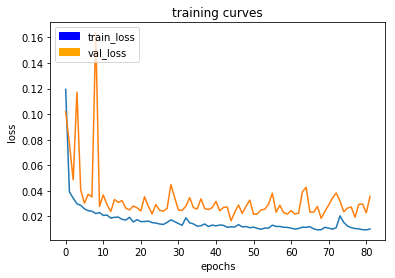

200/200 [==============================] - 112s - loss: 0.0102 - val_loss: 0.0357
Epoch 83/115
199/200 [============================>.] - ETA: 0s - loss: 0.0104

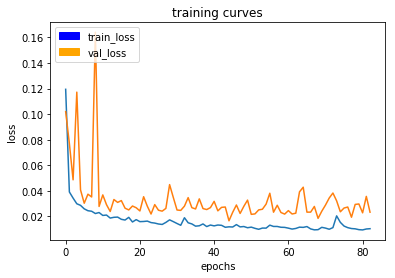

200/200 [==============================] - 113s - loss: 0.0104 - val_loss: 0.0233
Epoch 84/115
199/200 [============================>.] - ETA: 0s - loss: 0.0094

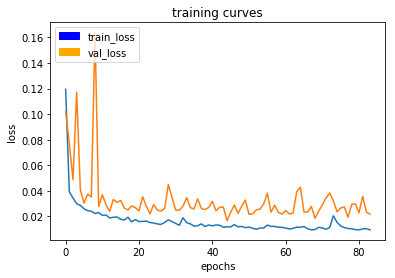

200/200 [==============================] - 112s - loss: 0.0095 - val_loss: 0.0218
Epoch 85/115
199/200 [============================>.] - ETA: 0s - loss: 0.0093

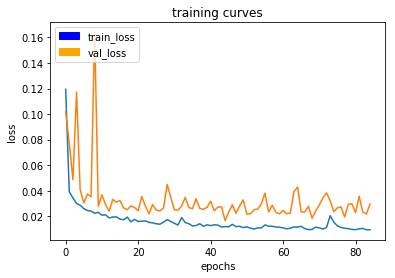

200/200 [==============================] - 113s - loss: 0.0093 - val_loss: 0.0296
Epoch 86/115
199/200 [============================>.] - ETA: 0s - loss: 0.0092

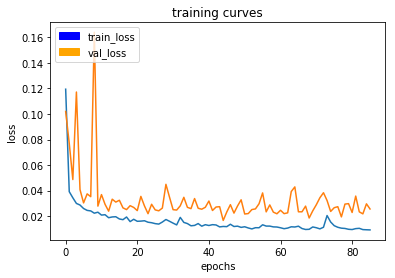

200/200 [==============================] - 113s - loss: 0.0092 - val_loss: 0.0256
Epoch 87/115
199/200 [============================>.] - ETA: 0s - loss: 0.0093

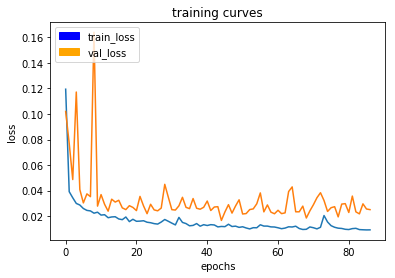

200/200 [==============================] - 113s - loss: 0.0093 - val_loss: 0.0251
Epoch 88/115
199/200 [============================>.] - ETA: 0s - loss: 0.0106

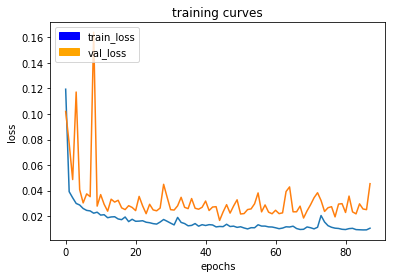

200/200 [==============================] - 112s - loss: 0.0106 - val_loss: 0.0454
Epoch 89/115
199/200 [============================>.] - ETA: 0s - loss: 0.0102

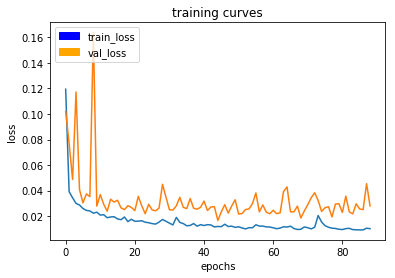

200/200 [==============================] - 113s - loss: 0.0102 - val_loss: 0.0280
Epoch 90/115
199/200 [============================>.] - ETA: 0s - loss: 0.0101

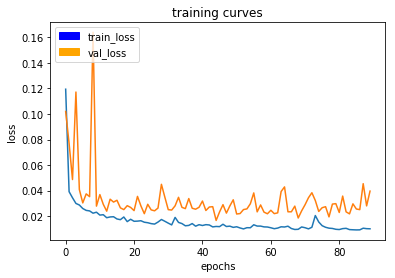

200/200 [==============================] - 111s - loss: 0.0101 - val_loss: 0.0396
Epoch 91/115
199/200 [============================>.] - ETA: 0s - loss: 0.0119

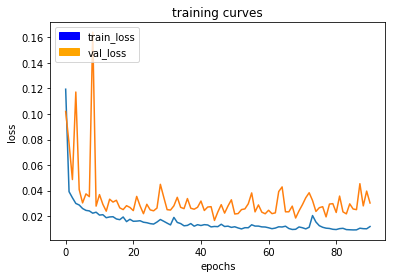

200/200 [==============================] - 112s - loss: 0.0119 - val_loss: 0.0303
Epoch 92/115
199/200 [============================>.] - ETA: 0s - loss: 0.0103

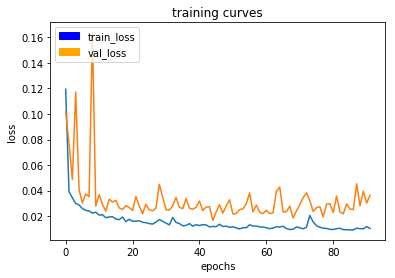

200/200 [==============================] - 112s - loss: 0.0103 - val_loss: 0.0363
Epoch 93/115
199/200 [============================>.] - ETA: 0s - loss: 0.0093

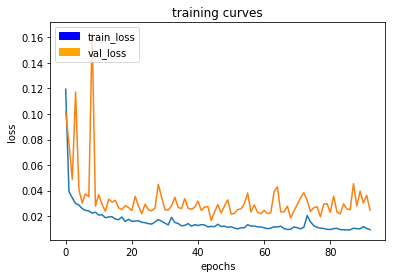

200/200 [==============================] - 112s - loss: 0.0093 - val_loss: 0.0246
Epoch 94/115
199/200 [============================>.] - ETA: 0s - loss: 0.0091

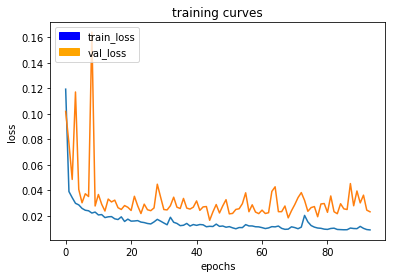

200/200 [==============================] - 113s - loss: 0.0091 - val_loss: 0.0233
Epoch 95/115
199/200 [============================>.] - ETA: 0s - loss: 0.0092

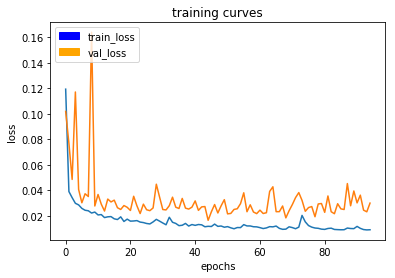

200/200 [==============================] - 113s - loss: 0.0092 - val_loss: 0.0301
Epoch 96/115
199/200 [============================>.] - ETA: 0s - loss: 0.0091

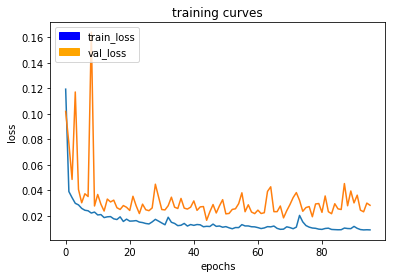

200/200 [==============================] - 113s - loss: 0.0091 - val_loss: 0.0284
Epoch 97/115
199/200 [============================>.] - ETA: 0s - loss: 0.0090

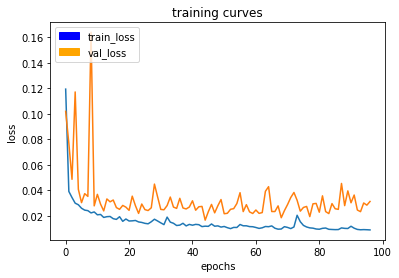

200/200 [==============================] - 112s - loss: 0.0090 - val_loss: 0.0313
Epoch 98/115
199/200 [============================>.] - ETA: 0s - loss: 0.0089

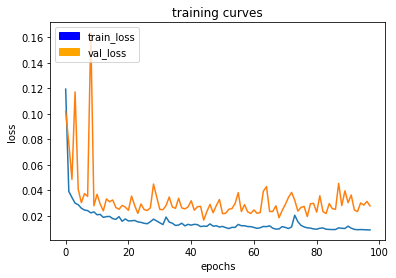

200/200 [==============================] - 113s - loss: 0.0089 - val_loss: 0.0278
Epoch 99/115
199/200 [============================>.] - ETA: 0s - loss: 0.0099

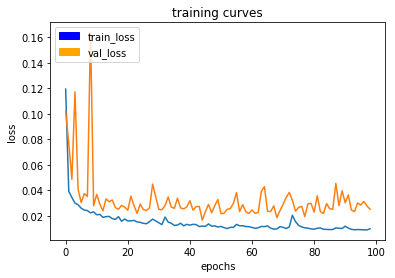

200/200 [==============================] - 112s - loss: 0.0099 - val_loss: 0.0251
Epoch 100/115
199/200 [============================>.] - ETA: 0s - loss: 0.0224

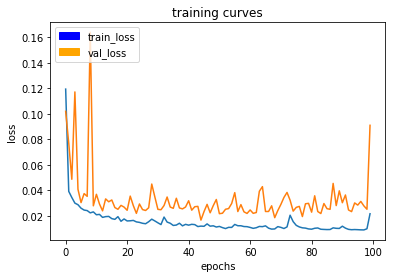

200/200 [==============================] - 113s - loss: 0.0225 - val_loss: 0.0910
Epoch 101/115
199/200 [============================>.] - ETA: 0s - loss: 0.0182

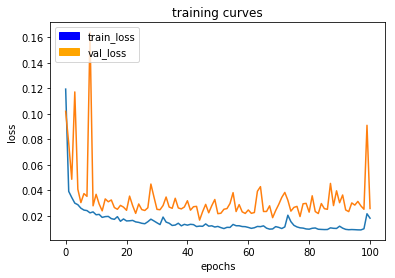

200/200 [==============================] - 112s - loss: 0.0182 - val_loss: 0.0257
Epoch 102/115
199/200 [============================>.] - ETA: 0s - loss: 0.0145

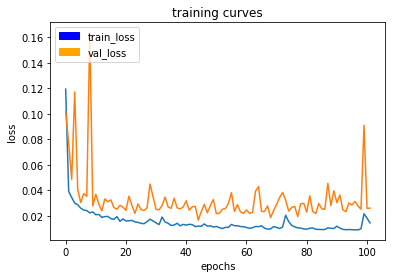

200/200 [==============================] - 114s - loss: 0.0145 - val_loss: 0.0260
Epoch 103/115
199/200 [============================>.] - ETA: 0s - loss: 0.0124

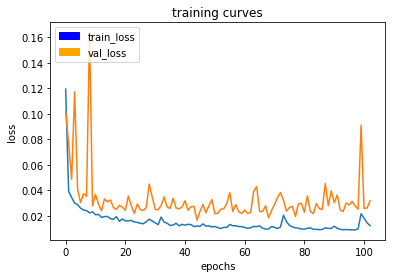

200/200 [==============================] - 112s - loss: 0.0124 - val_loss: 0.0316
Epoch 104/115
199/200 [============================>.] - ETA: 0s - loss: 0.0110

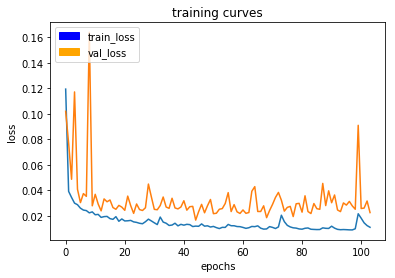

200/200 [==============================] - 112s - loss: 0.0110 - val_loss: 0.0225
Epoch 105/115
199/200 [============================>.] - ETA: 0s - loss: 0.0108

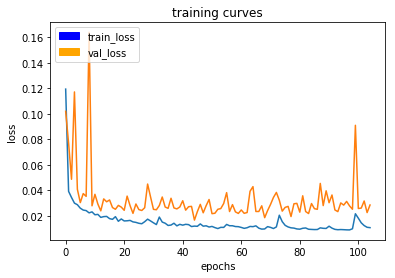

200/200 [==============================] - 113s - loss: 0.0108 - val_loss: 0.0285
Epoch 106/115
199/200 [============================>.] - ETA: 0s - loss: 0.0103

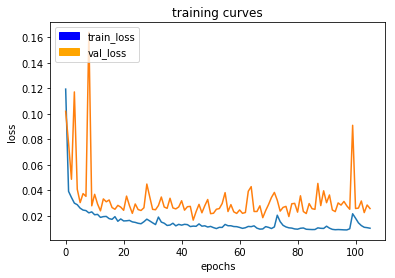

200/200 [==============================] - 112s - loss: 0.0103 - val_loss: 0.0257
Epoch 107/115
199/200 [============================>.] - ETA: 0s - loss: 0.0107

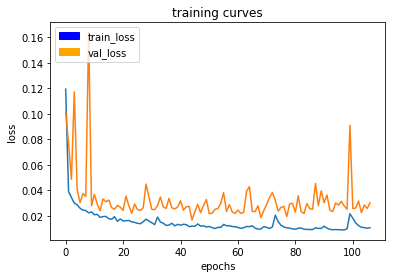

200/200 [==============================] - 112s - loss: 0.0107 - val_loss: 0.0302
Epoch 108/115
199/200 [============================>.] - ETA: 0s - loss: 0.0106

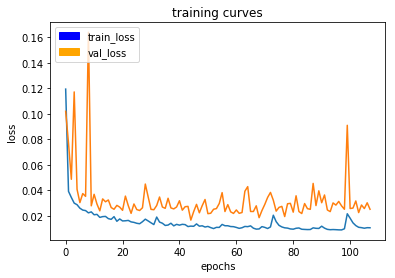

200/200 [==============================] - 113s - loss: 0.0106 - val_loss: 0.0251
Epoch 109/115
199/200 [============================>.] - ETA: 0s - loss: 0.0098

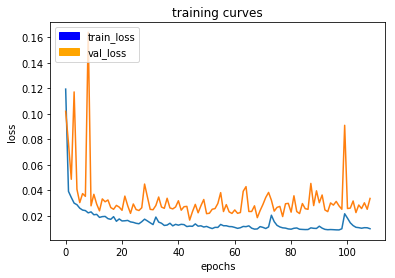

200/200 [==============================] - 113s - loss: 0.0098 - val_loss: 0.0336
Epoch 110/115
199/200 [============================>.] - ETA: 0s - loss: 0.0093

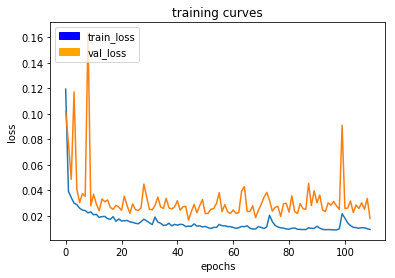

200/200 [==============================] - 112s - loss: 0.0093 - val_loss: 0.0179
Epoch 111/115
199/200 [============================>.] - ETA: 0s - loss: 0.0100

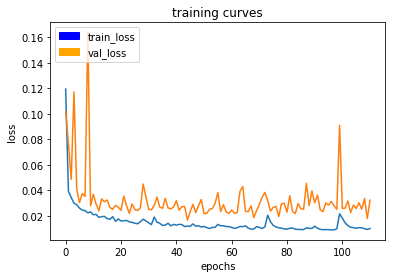

200/200 [==============================] - 113s - loss: 0.0100 - val_loss: 0.0322
Epoch 112/115
199/200 [============================>.] - ETA: 0s - loss: 0.0098

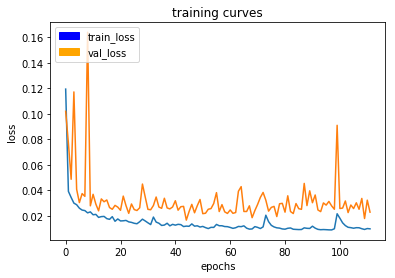

200/200 [==============================] - 112s - loss: 0.0098 - val_loss: 0.0228
Epoch 113/115
199/200 [============================>.] - ETA: 0s - loss: 0.0092

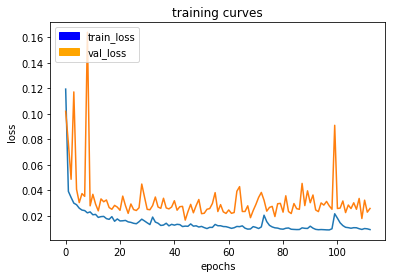

200/200 [==============================] - 112s - loss: 0.0092 - val_loss: 0.0258
Epoch 114/115
199/200 [============================>.] - ETA: 0s - loss: 0.0111

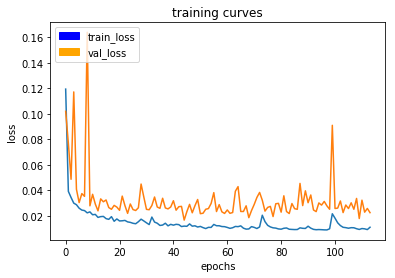

200/200 [==============================] - 113s - loss: 0.0111 - val_loss: 0.0225
Epoch 115/115
199/200 [============================>.] - ETA: 0s - loss: 0.0091

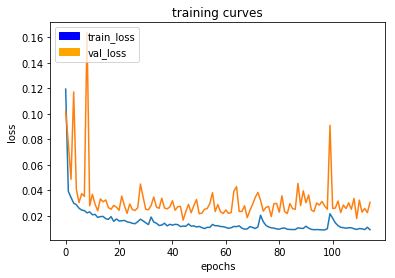

200/200 [==============================] - 113s - loss: 0.0091 - val_loss: 0.0306


In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [13]:
# Save your trained model weights
weight_file_name = 'model_weights_01'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [14]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [15]:
run_num = 'run_2'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

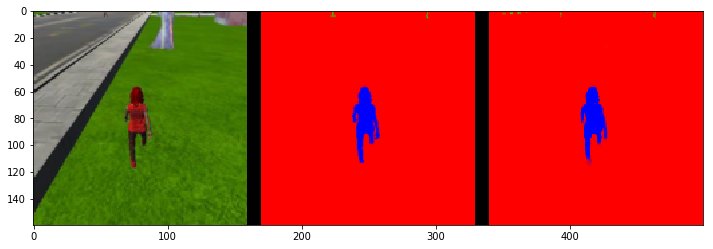

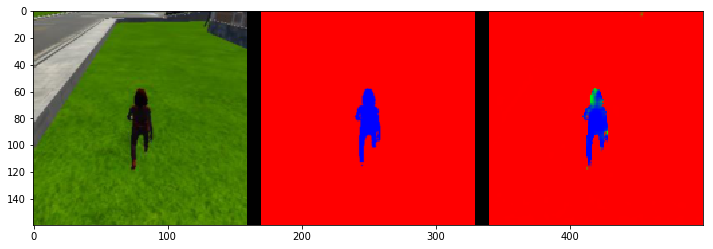

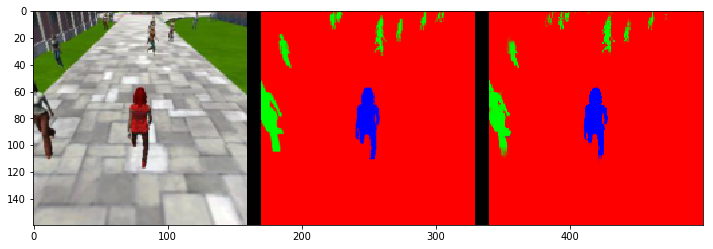

In [16]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

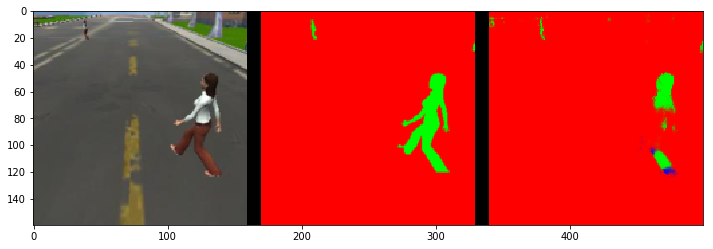

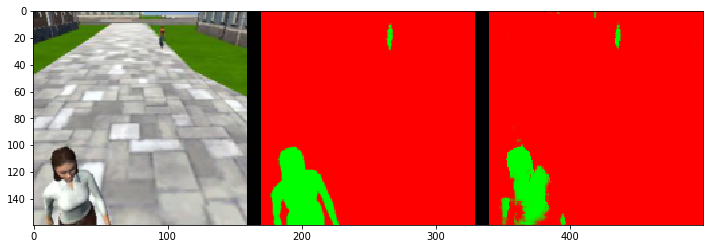

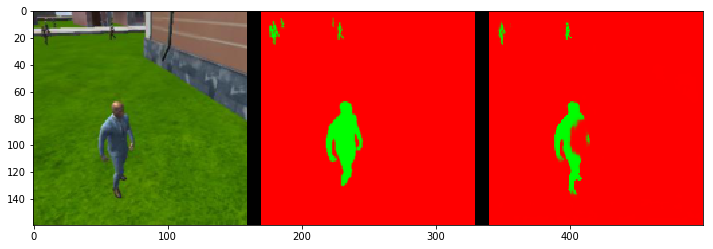

In [17]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

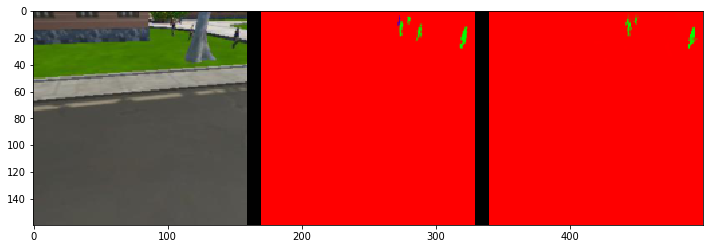

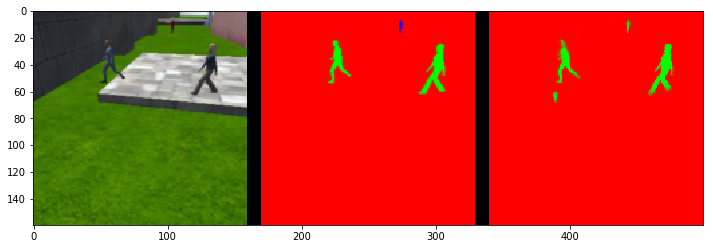

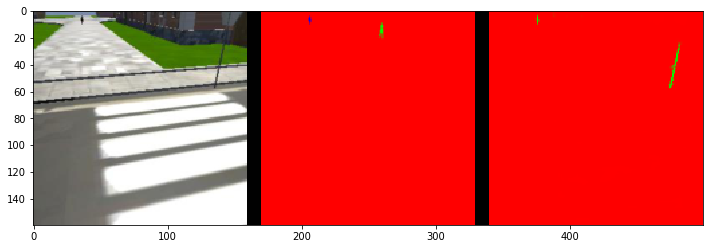

In [18]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [19]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9965457222108018
average intersection over union for other people is 0.4018328779965078
average intersection over union for the hero is 0.9243780427567977
number true positives: 539, number false positives: 0, number false negatives: 0


In [20]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9895129469709045
average intersection over union for other people is 0.792995878343493
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 40, number false negatives: 0


In [21]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9970756497071918
average intersection over union for other people is 0.4792198829927118
average intersection over union for the hero is 0.22224049493137998
number true positives: 119, number false positives: 1, number false negatives: 182


In [22]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7468785471055619


In [23]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.573309268844


In [24]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.428192393756
